In [1]:
import numpy as np
from scipy.stats import chi2, norm, multivariate_normal
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
%matplotlib inline

In [2]:
def cov_ellipse(cov, q=None, nsig=None, **kwargs):
    """
    Parameters
    ----------
    cov : (N, N) array
        Covariance matrix.
    q : float, optional
        Confidence level, should be in (0, 1)
    nsig : int, optional
        Confidence level in unit of standard deviations. 
        E.g. 1 stands for 68.3% and 2 stands for 95.4%.

    Returns
    -------
    width, height, rotation :
         The lengths of two axises and the rotation angle in degree
    for the ellipse.
    """

    if q is not None:
        q = np.asarray(q)
    elif nsig is not None:
        q = 2 * norm.cdf(nsig) - 1
    else:
        raise ValueError('One of `q` and `nsig` should be specified.')
    df = cov.shape[0]  # Degrees of freedom
    r2 = chi2.ppf(q, df)

    val, vec = np.linalg.eigh(cov)
    width, height = 2 * np.sqrt(val[:, None] * r2)
    rotation = np.degrees(np.arctan2(*vec[::-1, 0]))

    return width, height, rotation

The Mahalanobis distance squared is bounded by Chi-squared:

$({\mathbf x}-{\boldsymbol\mu})^T{\boldsymbol\Sigma}^{-1}({\mathbf x}-{\boldsymbol\mu}) \leq \chi^2_k(p).$

In [3]:
# Get Mahalanobis distance from confidence interval
pvalue = 0.995  # We want 99.5% of the samples to be inside the interval
df = 4  # Degrees of freedom
chi_sqr = chi2.ppf(pvalue, df)
nsig = np.sqrt(chi_sqr)  # Number of standard deviations
print(f"p-value: {pvalue} | DF: {df} | Number sigma (Mahalanobis distance): {nsig} ")

p-value: 0.995 | DF: 4 | Number sigma (Mahalanobis distance): 3.8549006473008154 


p-value: 0.95 | DF: 2 | Number sigma (Mahalanobis distance): 2.447746830680816 
Ellipse: Width: [6.56799397] | Height: [11.16344313] | Rotation: -75.96375653207353
Empirical p-value: 0.94


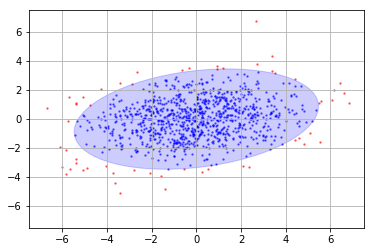

In [4]:
# 2D example - Get confidence ellipse

# Get Mahalanobis distance from confidence interval
pvalue = 0.95  # We want 99.5% of the samples to be inside the interval
df = 2  # Degrees of freedom
chi_sqr = chi2.ppf(pvalue, df)
nsig = np.sqrt(chi_sqr)  # Number of standard deviations
print(f"p-value: {pvalue} | DF: {df} | Number sigma (Mahalanobis distance): {nsig} ")

# Get confidence ellipse size
cov = np.array([[5.0, 0.8],
                [0.8, 2.0]])
width, height, theta = cov_ellipse(cov, pvalue)
print(f"Ellipse: Width: {width} | Height: {height} | Rotation: {theta}")
pos = np.array([0, 0])

# Generating empirical data
xy = multivariate_normal.rvs(cov=cov, size=(1000))
cov_inv = np.linalg.inv(cov)
mahalanobis = np.zeros(len(xy))
for n in range(len(mahalanobis)):
    mahalanobis[n] = (xy[n].dot(cov_inv)).dot(xy[n].T)
mahalanobis = np.sqrt(mahalanobis)
xy_in = mahalanobis < nsig
xy_out = mahalanobis >= nsig
pvalue_empirical = np.sum(xy_in)/float(len(xy))
print(f"Empirical p-value: {pvalue_empirical}")

# Plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(xy[xy_in][:, 0], xy[xy_in][:, 1], s=2, alpha=0.5, color='blue')
ax.scatter(xy[xy_out][:, 0], xy[xy_out][:, 1], s=2, alpha=0.5, color='red')
ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, alpha=0.2, color='blue')
ax.add_artist(ellip)
ax.grid()
ax.set_xlim([-7.5, 7.5])
ax.set_ylim([-7.5, 7.5]);

p-value: 0.995 | DF: 1 | Number sigma (Mahalanobis distance): 2.807033768343804 
Empirical p-value: 0.995012


(0, 0.45)

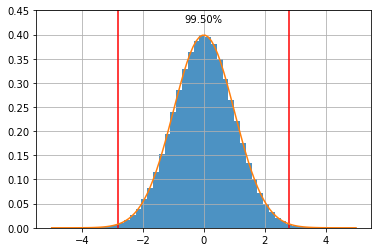

In [5]:
# 1D example

# Going from p-value to number of standard deviations
pvalue = 0.995
df = 1
chi_sqr = chi2.ppf(pvalue, df)
nsig = np.sqrt(chi_sqr)
print(f"p-value: {pvalue} | DF: {df} | Number sigma (Mahalanobis distance): {nsig} ")

# Generating empirical data
x = np.linspace(-5, 5, 100)
y = norm.rvs(size=1000000)
y_in = np.logical_and(y > -nsig, y < nsig)
y_out = ~np.logical_and(y > -nsig, y < nsig)
pvalue_empirical = np.sum(y_in)/float(len(y))
print(f"Empirical p-value: {pvalue_empirical}")

# Plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(y, alpha=0.8, bins=50, density=True)
ax.plot(x, norm.pdf(x))
ax.vlines(-nsig, ymin=0, ymax=0.45, color='red')
ax.vlines(nsig, ymin=0, ymax=0.45, color='red')
ax.text(0.5, 0.96, '%.2f%%' % (100.0*np.sum(y_in)/float(len(y))), horizontalalignment='center',
        verticalalignment='center', transform=ax.transAxes)
ax.grid()
ax.set_ylim([0, 0.45]);